In [31]:
import os
import pandas as pd
import numpy as np
import collections
import tables
import scipy.sparse as sp_sparse
from scipy.io import mmread
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "arial"

import seaborn as sns

import anndata
import scanpy as sc 

from pyInfinityFlow.InfinityFlow_Utilities import find_markers_from_anndata
from pyInfinityFlow.Plotting_Utilities import assign_rainbow_colors_to_groups

os.chdir("/media/kyle_storage/kyle_ferchen/grimes_lab_main/analysis/"\
    "2023_06_11_redo_harmony_knn_label_transfer_to_tea_seq/")

In [2]:
###############################################################################
# Helper functions
###############################################################################
print("Loading helper functions...")

def pprint(input_list):
    print("\n".join(input_list))

# CountMatrix required for `get_matrix_from_h5()`
CountMatrix = collections.namedtuple('CountMatrix', ['feature_ref', 'barcodes', 'matrix'])
def get_matrix_from_h5(filename):
    with tables.open_file(filename, 'r') as f:
        mat_group = f.get_node(f.root, 'matrix')
        barcodes = f.get_node(mat_group, 'barcodes').read()
        data = getattr(mat_group, 'data').read()
        indices = getattr(mat_group, 'indices').read()
        indptr = getattr(mat_group, 'indptr').read()
        shape = getattr(mat_group, 'shape').read()
        matrix = sp_sparse.csc_matrix((data, indices, indptr), shape=shape)
        feature_ref = {}
        feature_group = f.get_node(mat_group, 'features')
        feature_ids = getattr(feature_group, 'id').read()
        feature_names = getattr(feature_group, 'name').read()
        feature_types = getattr(feature_group, 'feature_type').read()
        feature_ref['id'] = feature_ids
        feature_ref['name'] = feature_names
        feature_ref['feature_type'] = feature_types
        tag_keys = getattr(feature_group, '_all_tag_keys').read()
        for key in tag_keys:
            feature_ref[key] = getattr(feature_group, key.decode("utf-8")).read()
            
        return CountMatrix(feature_ref, barcodes, matrix)


def check_and_rename_byte_strings(input_str):
    if type(input_str) == np.bytes_ or type(input_str) == bytes:
        return(input_str.decode("utf-8"))
    else:
        return(input_str)


def get_feature_annoation_from_10x_h5(input_h5_object):
    if type(input_h5_object) == CountMatrix:
        tmp_df = pd.DataFrame(input_h5_object.feature_ref)
        tmp_df.columns = [check_and_rename_byte_strings(item) for item in tmp_df.columns]
        for colname in tmp_df.columns:
            tmp_df[colname] = tmp_df[colname].apply(lambda x: check_and_rename_byte_strings(x))
        return(tmp_df)
    else:
        print("Error! Wrong input format! Needs to be of type <class '__main__.CountMatrix'>")
        return(None)


def pull_out_gene_expression(input_h5_object, feature_annotation):
    tmp_gene_indices = np.where(feature_annotation["feature_type"] == "Gene Expression")
    return(input_h5_object.matrix[tmp_gene_indices,:])
    
    
def make_list_items_unique(input_list):
    existing_items = {}
    output_list = []
    for tmp_item in input_list:
        if tmp_item in existing_items:
            output_list.append(tmp_item + "." + str(existing_items[tmp_item]))
            existing_items[tmp_item] += 1
        else:
            output_list.append(tmp_item)
            existing_items[tmp_item] = 1
    return(np.array(output_list))
  
  
def make_anndata_sparse_gex_from_h5_path(path_to_h5, tmp_sample_name):
    print("Working on sample {}".format(tmp_sample_name))
    print("\tLoading h5 file...")
    tmp_h5_obj = get_matrix_from_h5(path_to_h5)
    tmp_fanno = get_feature_annoation_from_10x_h5(tmp_h5_obj)
    tmp_gene_indices = np.where(tmp_fanno["feature_type"] == "Gene Expression")[0]
    tmp_adt_indices = np.where(tmp_fanno["feature_type"] == "Antibody Capture")[0]
    tmp_barcodes = np.array([check_and_rename_byte_strings(item) for item in tmp_h5_obj.barcodes])
    tmp_barcode_df = pd.DataFrame({"cell": tmp_barcodes,
        "sample": tmp_sample_name},
        index=(pd.Series(tmp_barcodes) + "." + tmp_sample_name).values)
    tmp_feature_df = pd.DataFrame(tmp_fanno.iloc[tmp_gene_indices].values,
        index=make_list_items_unique(tmp_fanno.iloc[tmp_gene_indices]["name"].values),
        columns=tmp_fanno.columns.values)
    tmp_protein_df = pd.DataFrame(tmp_h5_obj.matrix[tmp_adt_indices,:].toarray().T,
        index=tmp_barcode_df.index.values,
        columns=make_list_items_unique(tmp_fanno.iloc[tmp_adt_indices]["name"].values))
    print("\tCreating AnnData object...")
    tmp_anndata = anndata.AnnData(X=pd.DataFrame.sparse.from_spmatrix(tmp_h5_obj.matrix[tmp_gene_indices,:].T,
                index=tmp_barcode_df.index.values,
                columns=tmp_feature_df.index.values),
        obs=tmp_barcode_df,
        var=tmp_feature_df)
    tmp_anndata.obsm["protein_expression"] = tmp_protein_df
    print("Done.")
    print("")
    return(tmp_anndata)


def annotate_gene_umi_metrics(input_adata, organism):
    if organism == "Mm":
        mito_prefix = "mt-"
    elif organism == "Hs":
        mito_prefix = "MT-"
    else:
        raise Exception("<organism> not recognized... (\"Mm\" and \"Hs\" supported.)")
    mito_genes = input_adata.var.index.values[pd.Series(input_adata.var.index).str.contains(mito_prefix).values]
    n_umi_gene = np.asarray(input_adata.X.sum(axis=1)).reshape(-1)
    total_counts_mito = np.asarray(input_adata.X[:, [list(input_adata.var.index.values).index(item) for item in mito_genes]].sum(axis=1)).reshape(-1)
    tmp_df = pd.DataFrame({"n_umi_gene": n_umi_gene,
            "n_gene": np.asarray((input_adata.X > 0).sum(axis=1)).reshape(-1),
            "total_counts_mito": total_counts_mito,
            "pct_counts_mito": 100 * (total_counts_mito / (1+n_umi_gene))},
        index=input_adata.obs.index.values)
    input_adata.obs = pd.concat([input_adata.obs[input_adata.obs.columns.values[~np.isin(input_adata.obs.columns.values, tmp_df.columns.values)]],
        tmp_df], axis=1)
  
  
def annotate_hash_umi_metrics(input_adata, list_of_hash_names):
  if len(list_of_hash_names) == np.sum([item in input_adata.obsm["protein_expression"].columns.values for item in list_of_hash_names]):
    tmp_hash_df = input_adata.obsm["protein_expression"][list_of_hash_names].copy()
    frequency = (tmp_hash_df.T / tmp_hash_df.sum(axis=1)).T
    first_indices = frequency.apply(\
        lambda x: np.argsort(x.values)[-1], axis=1)
    second_indices = frequency.apply(\
        lambda x: np.argsort(x.values)[-2], axis=1)
    second_values = second_indices.reset_index().apply(\
        lambda x: frequency.loc[x["index"]].iloc[x[0]], axis=1).values
    second_values[second_values == 0] = 0.001
    first_over_second = \
        first_indices.reset_index().apply(\
            lambda x: frequency.loc[x["index"]].iloc[x[0]], axis=1).values \
        / second_values
    tmp_df = pd.DataFrame({"n_umi_hash": tmp_hash_df.sum(axis=1).values,
			    "top_hash": frequency.idxmax(axis=1),
			    "top_hash_frequency": frequency.max(axis=1),
                "first_over_second_freq": first_over_second},
			    index=input_adata.obs.index.values)
    input_adata.obs = pd.concat([input_adata.obs[input_adata.obs.columns.values[~np.isin(input_adata.obs.columns.values, tmp_df.columns.values)]],
				 tmp_df], axis=1)
  else:
    raise ValueError("Hash names not found in input_adata.obsm[\"protein_expression\"] !")
  

def separate_isotype_adt_expression(input_adata, isotype_adts):
    input_adata.obsm["isotype_protein_expression"] = input_adata.obsm["protein_expression"][isotype_adts].copy()
    input_adata.obsm["protein_expression"] = input_adata.obsm["protein_expression"].drop(labels=isotype_adts, axis=1)


def add_pct_mt_expression_to_anndata(input_adata):
    index_mt_genes = np.where([item.lower().startswith("mt-") for item in input_adata.var.index.values])[0]
    n_umi_mt_genes = np.asarray(input_adata.X[:,index_mt_genes].sum(axis=1)).reshape(-1)
    n_umi_all_genes = np.asarray(input_adata.X.sum(axis=1)).reshape(-1)
    input_adata.obs["pct_mt_genes"] = 100 * (n_umi_mt_genes / n_umi_all_genes)


def normalize_x_by_log2_cptt(input_adata):
    input_adata.X = sp_sparse.csr_matrix(np.log2((1e4 * (input_adata.X / input_adata.X.sum(axis=1))) + 1))

Loading helper functions...


In [3]:
# Read in the transferred labels from CITE-seq to TEA-seq
tea_cell_anno = pd.read_csv("output/tea_seq_r7_label_transfer_from_cite_seq_06_2023.csv")
tea_cell_anno.index = tea_cell_anno["cell"].values

tea_cell_anno

,cell,R7
AAACAGCCAACTGGCT-1.AS_TEAr_M1,AAACAGCCAACTGGCT-1.AS_TEAr_M1,ML-cell-cycle
AAACAGCCACAATGTT-1.AS_TEAr_M1,AAACAGCCACAATGTT-1.AS_TEAr_M1,MPP5-Egr1
AAACAGCCACGTAAGG-1.AS_TEAr_M1,AAACAGCCACGTAAGG-1.AS_TEAr_M1,proNeu-1
AAACAGCCAGGACCAA-1.AS_TEAr_M1,AAACAGCCAGGACCAA-1.AS_TEAr_M1,MDP-Cpa3
AAACAGCCAGTTTGGC-1.AS_TEAr_M1,AAACAGCCAGTTTGGC-1.AS_TEAr_M1,IG2-proNeu1
...,...,...
TTTGTGTTCTCCTCAA-1.AS_TEAr_H2,TTTGTGTTCTCCTCAA-1.AS_TEAr_H2,ST-HSC
TTTGTGTTCTTACTCG-1.AS_TEAr_H2,TTTGTGTTCTTACTCG-1.AS_TEAr_H2,HSCP-HPC_Tk1
TTTGTTGGTCAGTAAT-1.AS_TEAr_H2,TTTGTTGGTCAGTAAT-1.AS_TEAr_H2,MPP5-Egr1
TTTGTTGGTGCACGCA-1.AS_TEAr_H2,TTTGTTGGTGCACGCA-1.AS_TEAr_H2,ST-HSC


In [4]:
### Read in the CITE-seq data
# Cell annotations
print("Preparing cell annotations...")
path_r7_annotations = "/media/kyle_storage/kyle_ferchen/grimes_lab_main/data/"\
    "2021_11_mouse_optimized_cite_seq/processed_files/"\
    "cell_anno_cite_r7_all_cells.csv"

cite_anno = pd.read_csv(path_r7_annotations)
cite_anno.index = cite_anno["cell"]

# 10X Cellranger count h5 file import
print("Reading in 10X genomics cellranger count data...")
path_cite_seq_data = "/media/kyle_storage/kyle_ferchen/grimes_lab_main/data/"\
    "2021_11_mouse_optimized_cite_seq/outs_10x/"

rna_cite_hsc = make_anndata_sparse_gex_from_h5_path(os.path.join(\
        path_cite_seq_data, 
        "AS_CITE_HSC", 
        "filtered_feature_bc_matrix.h5"), 
    "AS_CITE_HSC")

rna_cite_ml1 = make_anndata_sparse_gex_from_h5_path(os.path.join(\
        path_cite_seq_data, 
        "AS_CITE_Multilin1", 
        "filtered_feature_bc_matrix.h5"), 
    "AS_CITE_Multilin1")

rna_cite_ml2 = make_anndata_sparse_gex_from_h5_path(os.path.join(\
        path_cite_seq_data, 
        "AS_CITE_Multilin2", 
        "filtered_feature_bc_matrix.h5"), 
    "AS_CITE_Multilin2")


# Merge and normalize data
print("Merging RNA captures...")
rna_cite_merged = anndata.concat(\
    [rna_cite_hsc, rna_cite_ml1, rna_cite_ml2], 
    merge="same")

rna_cite_merged_raw_counts = rna_cite_merged.copy()


print("Normlizing merged RNA data by CPTT...")
normalize_x_by_log2_cptt(rna_cite_merged)

Preparing cell annotations...
Reading in 10X genomics cellranger count data...
Working on sample AS_CITE_HSC
	Loading h5 file...
	Creating AnnData object...


/tmp/ipykernel_1843184/909871885.py:90: FutureWarning: X.dtype being converted to np.float32 from int32. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  tmp_anndata = anndata.AnnData(X=pd.DataFrame.sparse.from_spmatrix(tmp_h5_obj.matrix[tmp_gene_indices,:].T,


Done.

Working on sample AS_CITE_Multilin1
	Loading h5 file...
	Creating AnnData object...
Done.

Working on sample AS_CITE_Multilin2
	Loading h5 file...
	Creating AnnData object...
Done.

Merging RNA captures...
Normlizing merged RNA data by CPTT...


In [5]:
# Filter down to multilin RNA data from cite-seq and add r7 annotations
rna_cite_ml_logcptt = rna_cite_merged[\
    cite_anno.loc[\
        cite_anno["port"].isin(["AS_CITE_Multilin1", "AS_CITE_Multilin2"]), 
        "cell"].values,:].copy()

rna_cite_ml_logcptt.obs["R7"] = cite_anno.loc[\
    rna_cite_ml_logcptt.obs.index.values, "cluster"].values

# Subset to clusters with at least 25 cells
tmp_start = rna_cite_ml_logcptt.obs.shape[0]
tmp_vcounts = rna_cite_ml_logcptt.obs["R7"].value_counts()
subset_i = rna_cite_ml_logcptt.obs.loc[rna_cite_ml_logcptt.obs["R7"].isin(\
    tmp_vcounts.loc[tmp_vcounts > 25].index.values)].index.values

rna_cite_ml_logcptt = rna_cite_ml_logcptt[subset_i,:]
tmp_end = rna_cite_ml_logcptt.obs.shape[0]

print("Filtered {} cells down to {}...".format(tmp_start, tmp_end))

Filtered 12052 cells down to 11917...


In [6]:
# Filter down to hscp RNA data from cite-seq and add r7 annotations
rna_cite_hscp_logcptt = rna_cite_merged[\
    cite_anno.loc[\
        cite_anno["port"].isin(["AS_CITE_HSC"]), 
        "cell"].values,:].copy()

rna_cite_hscp_logcptt.obs["R7"] = cite_anno.loc[\
    rna_cite_hscp_logcptt.obs.index.values, "cluster"].values

# Subset to clusters with at least 25 cells
tmp_start = rna_cite_hscp_logcptt.obs.shape[0]
tmp_vcounts = rna_cite_hscp_logcptt.obs["R7"].value_counts()
subset_i = rna_cite_hscp_logcptt.obs.loc[rna_cite_hscp_logcptt.obs["R7"].isin(\
    tmp_vcounts.loc[tmp_vcounts > 25].index.values)].index.values

rna_cite_hscp_logcptt = rna_cite_hscp_logcptt[subset_i,:]
tmp_end = rna_cite_hscp_logcptt.obs.shape[0]

print("Filtered {} cells down to {}...".format(tmp_start, tmp_end))

Filtered 8034 cells down to 7807...


In [7]:
### Read in the TEA-seq data
# 10X Cellranger arc h5 file import
print("Reading in 10X genomics cellranger arc data...")
path_tea_seq_data = "/media/kyle_storage/kyle_ferchen/grimes_lab_main/data/"\
    "2021_12_mouse_tea_seq/cellRanger-ARC/"

rna_tea_h1 = make_anndata_sparse_gex_from_h5_path(os.path.join(\
        path_tea_seq_data, 
        "AS_TEAr_H1", 
        "filtered_feature_bc_matrix.h5"), 
    "AS_TEAr_H1")

rna_tea_h2 = make_anndata_sparse_gex_from_h5_path(os.path.join(\
        path_tea_seq_data, 
        "AS_TEAr_H2", 
        "filtered_feature_bc_matrix.h5"), 
    "AS_TEAr_H2")

rna_tea_m1 = make_anndata_sparse_gex_from_h5_path(os.path.join(\
        path_tea_seq_data, 
        "AS_TEAr_ML1", 
        "filtered_feature_bc_matrix.h5"), 
    "AS_TEAr_M1")

rna_tea_m2 = make_anndata_sparse_gex_from_h5_path(os.path.join(\
        path_tea_seq_data, 
        "AS_TEAr_ML2", 
        "filtered_feature_bc_matrix.h5"), 
    "AS_TEAr_M2")


# Merge and normalize data
print("Merging TEA captures...")
rna_tea_merged = anndata.concat(\
    [rna_tea_h1, rna_tea_h2, rna_tea_m1, rna_tea_m2], 
    merge="same")

rna_tea_merged_raw_counts = rna_tea_merged.copy()


print("Normlizing merged TEA data by CPTT...")
normalize_x_by_log2_cptt(rna_tea_merged)

Reading in 10X genomics cellranger arc data...
Working on sample AS_TEAr_H1
	Loading h5 file...
	Creating AnnData object...


/tmp/ipykernel_1843184/909871885.py:90: FutureWarning: X.dtype being converted to np.float32 from int32. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  tmp_anndata = anndata.AnnData(X=pd.DataFrame.sparse.from_spmatrix(tmp_h5_obj.matrix[tmp_gene_indices,:].T,


Done.

Working on sample AS_TEAr_H2
	Loading h5 file...
	Creating AnnData object...
Done.

Working on sample AS_TEAr_M1
	Loading h5 file...
	Creating AnnData object...
Done.

Working on sample AS_TEAr_M2
	Loading h5 file...
	Creating AnnData object...
Done.

Merging TEA captures...
Normlizing merged TEA data by CPTT...


In [8]:
# Attach transferred R7 labels to obs metadata
rna_tea_merged.obs["R7"] = tea_cell_anno.loc[\
    rna_tea_merged.obs.index.values, "R7"].values

rna_tea_merged.obs

,cell,sample,R7
AAACAGCCAAACCCTA-1.AS_TEAr_H1,AAACAGCCAAACCCTA-1,AS_TEAr_H1,ST-HSC
AAACAGCCAATTTAGC-1.AS_TEAr_H1,AAACAGCCAATTTAGC-1,AS_TEAr_H1,HSCP-HPC_Tk1
AAACAGCCACCAGCAT-1.AS_TEAr_H1,AAACAGCCACCAGCAT-1,AS_TEAr_H1,LT-HSC_Mllt3
AAACAGCCAGCTCAAC-1.AS_TEAr_H1,AAACAGCCAGCTCAAC-1,AS_TEAr_H1,HSCP-HPC_Cenpf
AAACAGCCAGGAACTG-1.AS_TEAr_H1,AAACAGCCAGGAACTG-1,AS_TEAr_H1,eHSC-Pcna
...,...,...,...
TTTGTTGGTATTCGTC-1.AS_TEAr_M2,TTTGTTGGTATTCGTC-1,AS_TEAr_M2,pre-MultiLin-1
TTTGTTGGTCTATCGT-1.AS_TEAr_M2,TTTGTTGGTCTATCGT-1,AS_TEAr_M2,IG2-MP
TTTGTTGGTGACCTGG-1.AS_TEAr_M2,TTTGTTGGTGACCTGG-1,AS_TEAr_M2,immNeu-3
TTTGTTGGTGTCACGG-1.AS_TEAr_M2,TTTGTTGGTGTCACGG-1,AS_TEAr_M2,IG2-proNeu1


In [9]:
# Assign colors to R7 groups
tmp_colors_r7 = assign_rainbow_colors_to_groups(rna_tea_merged.obs["R7"].values)
tmp_colors_r7

{'BMCP': '#8000ff',
 'Baso': '#780dff',
 'CD127-MP': '#7019ff',
 'CHILP': '#6629fe',
 'CLP1-Hist1h1c': '#5e35fe',
 'CLP1-Rrm2': '#5444fd',
 'CLP2': '#4c50fc',
 'DN4-DP-trans_Hist1h3c': '#425ffa',
 'ERP1': '#396bf9',
 'ERP2': '#3079f7',
 'ETP-A-0': '#2884f6',
 'ETP-CC-4': '#1e91f3',
 'Ebf1+ proB_Hmga2': '#169bf2',
 'Eosinophils': '#0ca7ef',
 'HSC-Mac_Fcna': '#04b0ed',
 'HSCP-ERP1': '#07bbea',
 'HSCP-HPC_Cenpf': '#0fc4e7',
 'HSCP-HPC_Hist1h2af': '#18cde4',
 'HSCP-HPC_Tk1': '#20d5e1',
 'HSCP-MKP': '#2adddd',
 'IG2-MP': '#32e3da',
 'IG2-proNeu1': '#3dead5',
 'LT-HSC_Mllt3': '#44eed2',
 'MDP-Cpa3': '#4ef3cd',
 'MDP-Irf8': '#56f7ca',
 'MEP': '#60fac5',
 'MKP': '#68fcc1',
 'ML-Mast': '#72febb',
 'ML-cell-cycle': '#7affb7',
 'MPP4-Ccr9': '#84ffb2',
 'MPP4-Hlf': '#8cfead',
 'MPP4-Nkx2-3': '#96fca7',
 'MPP5-Egr1': '#9efaa2',
 'MPP5-Flt3': '#a8f79c',
 'MultiLin-1': '#b0f397',
 'MultiLin-1_MEP': '#bbee91',
 'MultiLin-1_preBMCP': '#c2ea8c',
 'MultiLin-2_F13a1': '#cce385',
 'MultiLin-2_Ms4a3': '#d4d

In [10]:
# Only consider genes shared between tea and cite captures
shared_genes = np.intersect1d(\
    rna_cite_merged.var.index.values,
    rna_tea_merged.var.index.values)

rna_cite_merged = rna_cite_merged[:,shared_genes]
rna_tea_merged = rna_tea_merged[:,shared_genes]

Finding markers for Infinity Flow object...
Plotting markers...


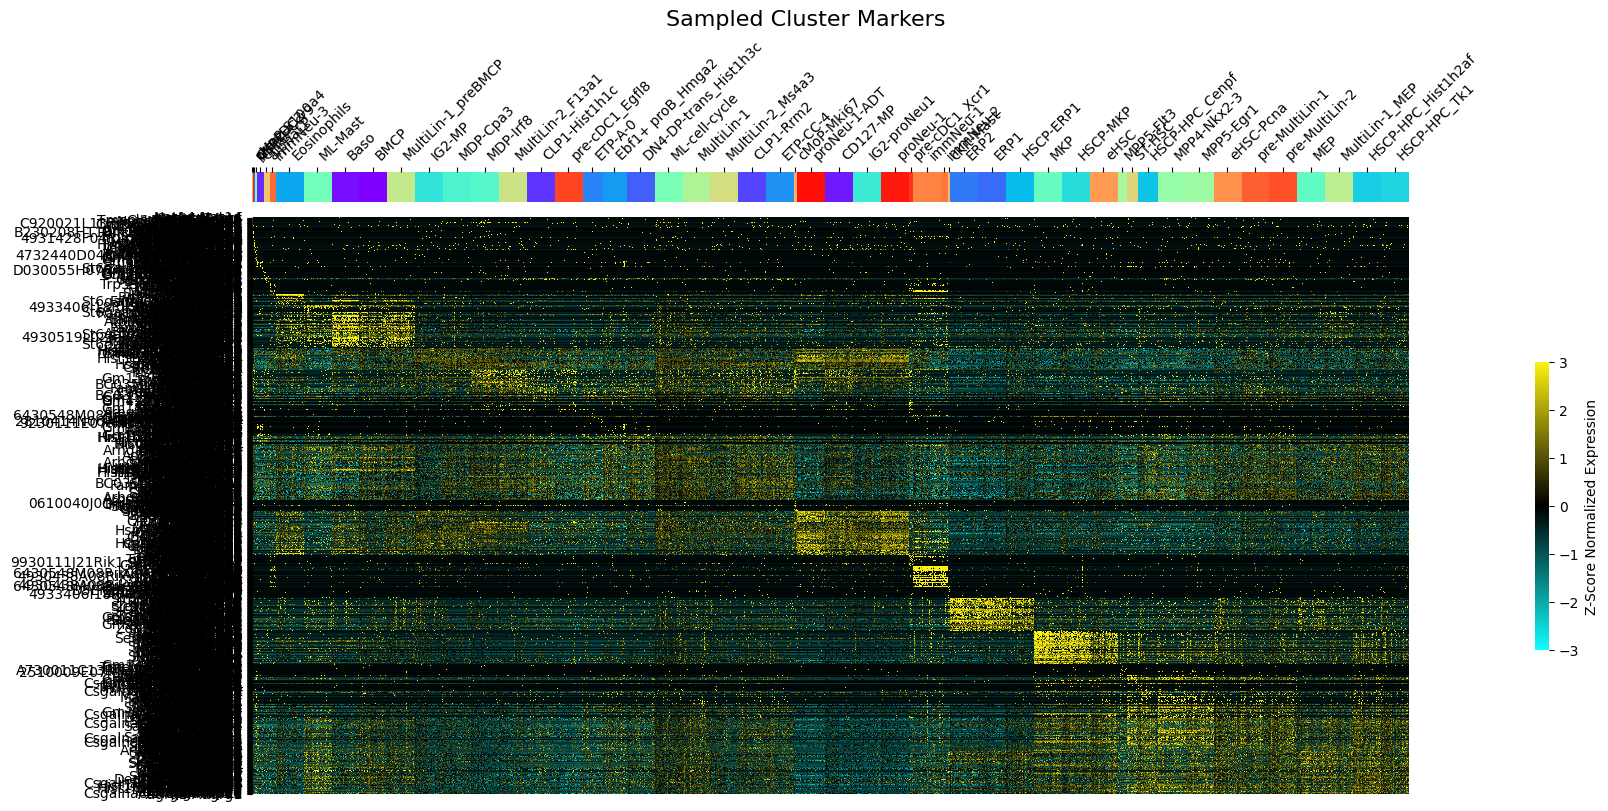

In [11]:
# Filter to multilin tea_seq data and find RNA markers

rna_tea_multilin = rna_tea_merged[\
    rna_tea_merged.obs.loc[\
        rna_tea_merged.obs["sample"].isin([\
            "AS_TEAr_M1",
            "AS_TEAr_M2"])].index.values].copy()



## Gene selection
tmp_cells_per_gene = pd.Series((\
    rna_tea_multilin.X > 0).toarray().sum(axis=0).reshape(-1),
    index=rna_tea_multilin.var.index.values)

# Force genes to be above 0 log2 cptt in at least 25 cells
tmp_cells_per_gene = tmp_cells_per_gene[tmp_cells_per_gene > 25]

# Exclude mitochondrial genes
tmp_cells_per_gene = tmp_cells_per_gene.loc[\
    ~tmp_cells_per_gene.index.str.startswith("mt-")]

tmp_input_adata = rna_tea_multilin[:,tmp_cells_per_gene.index.values].copy()
tmp_input_adata.X = tmp_input_adata.X.toarray()

cite_ml_marker_genes = find_markers_from_anndata(\
    tmp_input_adata, 
    output_dir="output/markerfinder/tea_transferred_multilin/", 
    groups_to_colors=tmp_colors_r7, 
    top_n_markers=25, 
    cluster_key='R7', 
    verbosity=3)

Finding markers for Infinity Flow object...
Plotting markers...


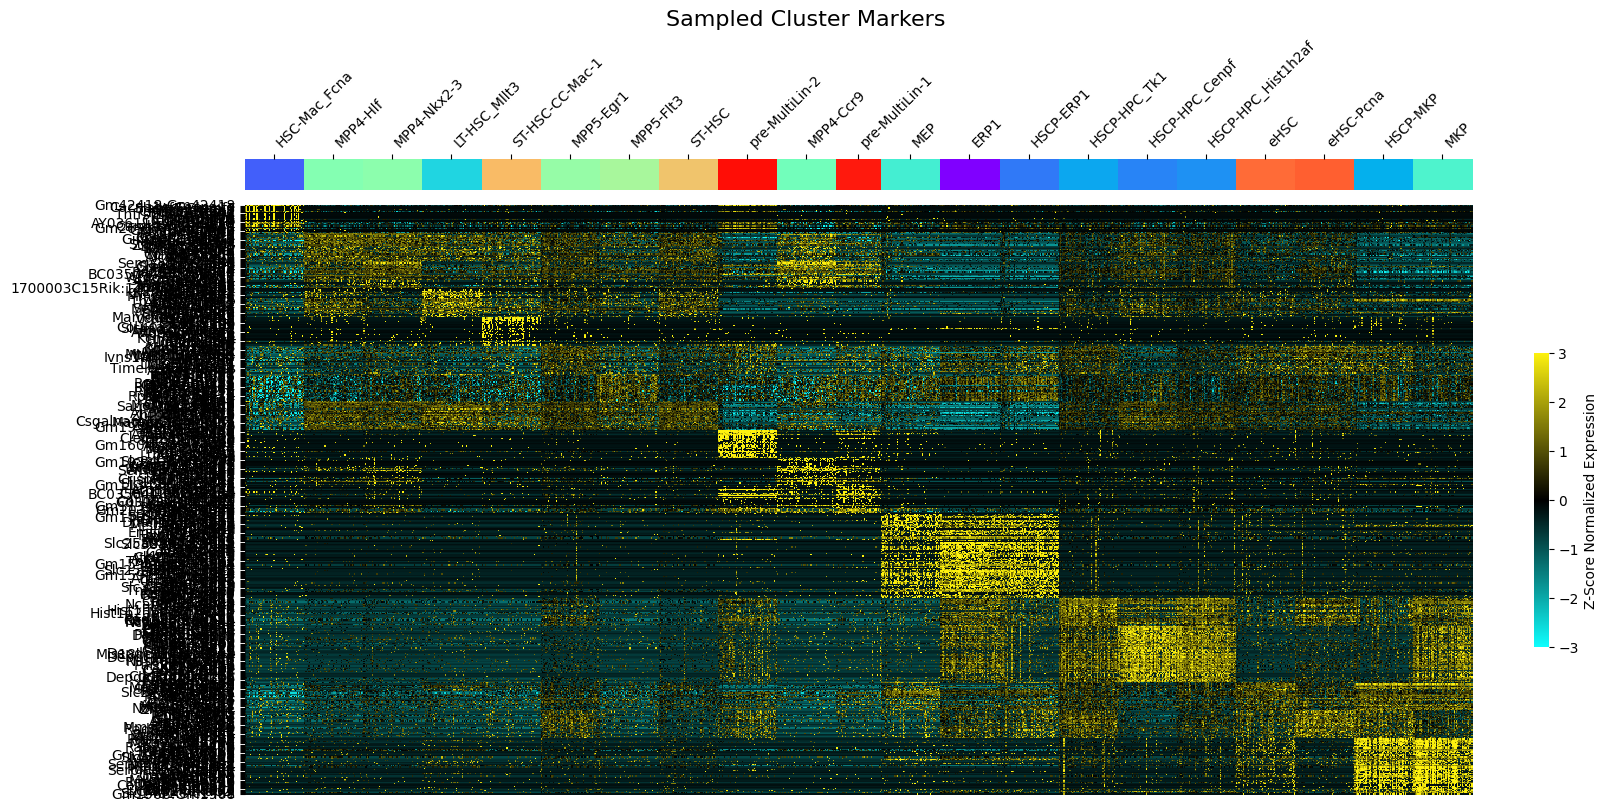

In [12]:
# Filter to hscp tea_seq data and find RNA markers

rna_tea_hscp = rna_tea_merged[\
    rna_tea_merged.obs.loc[\
        rna_tea_merged.obs["sample"].isin([\
            "AS_TEAr_H1",
            "AS_TEAr_H2"])].index.values].copy()



## Gene selection
tmp_cells_per_gene = pd.Series((\
    rna_tea_hscp.X > 0).toarray().sum(axis=0).reshape(-1),
    index=rna_tea_hscp.var.index.values)

# Force genes to be above 0 log2 cptt in at least 25 cells
tmp_cells_per_gene = tmp_cells_per_gene[tmp_cells_per_gene > 25]

# Exclude mitochondrial genes
tmp_cells_per_gene = tmp_cells_per_gene.loc[\
    ~tmp_cells_per_gene.index.str.startswith("mt-")]

tmp_input_adata = rna_tea_hscp[:,tmp_cells_per_gene.index.values].copy()
tmp_input_adata.X = tmp_input_adata.X.toarray()

cite_hscp_marker_genes = find_markers_from_anndata(\
    tmp_input_adata, 
    output_dir="output/markerfinder/tea_transferred_hscp/", 
    groups_to_colors=tmp_colors_r7, 
    top_n_markers=25, 
    cluster_key='R7', 
    verbosity=3)

In [13]:
cite_ml_marker_genes[1]["top_cluster"].unique()

array(['cMoP-S100a4', 'pre-cDC2', 'CLP2', 'MPP4-Ccr9', 'CHILP', 'alphaLP',
       'immNeu-3', 'Eosinophils', 'ML-Mast', 'Baso', 'BMCP',
       'MultiLin-1_preBMCP', 'IG2-MP', 'MDP-Cpa3', 'MDP-Irf8',
       'MultiLin-2_F13a1', 'CLP1-Hist1h1c', 'pre-cDC1_Egfl8', 'ETP-A-0',
       'Ebf1+ proB_Hmga2', 'DN4-DP-trans_Hist1h3c', 'ML-cell-cycle',
       'MultiLin-1', 'MultiLin-2_Ms4a3', 'CLP1-Rrm2', 'ETP-CC-4',
       'cMoP-Mki67', 'proNeu-1-ADT', 'CD127-MP', 'IG2-proNeu1',
       'proNeu-1', 'pre-cDC1_Xcr1', 'immNeu-1', 'immNeu-2', 'cKit-Mast',
       'ERP2', 'ERP1', 'HSCP-ERP1', 'MKP', 'HSCP-MKP', 'eHSC',
       'MPP5-Flt3', 'ST-HSC', 'HSCP-HPC_Cenpf', 'MPP4-Nkx2-3',
       'MPP5-Egr1', 'eHSC-Pcna', 'pre-MultiLin-1', 'pre-MultiLin-2',
       'MEP', 'MultiLin-1_MEP', 'HSCP-HPC_Hist1h2af', 'HSCP-HPC_Tk1'],
      dtype=object)

Go back and compare marker genes between cite-seq and tea-seq

In [14]:
from pyInfinityFlow.InfinityFlow_Utilities import marker_finder

In [15]:
tea_multilin_top_25_marker_df = pd.read_csv(\
    "output/markerfinder/tea_transferred_multilin/top_25_cluster_markers.csv")

markers_multilin = np.unique([i.split(":")[0] for i in \
    tea_multilin_top_25_marker_df["marker"].values])

tea_multilin_top_25_marker_df

,UID,cluster,marker,rank,pearson_r,p_value
0,0,cMoP-S100a4,Nat14:Nat14,1,0.142640,2.468530e-122
1,1,cMoP-S100a4,Gcnt4:Gcnt4,2,0.138469,2.490664e-115
2,2,cMoP-S100a4,Myof:Myof,3,0.085812,3.590764e-45
3,3,cMoP-S100a4,Acot1:Acot1,4,0.084912,2.909995e-44
4,4,cMoP-S100a4,Nr4a1:Nr4a1,5,0.061744,3.703592e-24
...,...,...,...,...,...,...
1320,20,HSCP-HPC_Tk1,Top2a:Top2a,21,0.082394,9.042691e-42
1321,21,HSCP-HPC_Tk1,Apoe:Apoe,22,0.082002,2.174783e-41
1322,22,HSCP-HPC_Tk1,Csgalnact1:Csgalnact1,23,0.080711,3.804112e-40
1323,23,HSCP-HPC_Tk1,Arid1b:Arid1b,24,0.080654,4.314028e-40


In [16]:
cite_multilin_mf_res = marker_finder(\
    pd.DataFrame(\
        rna_cite_ml_logcptt[:,markers_multilin].X.toarray(),
        index=rna_cite_ml_logcptt.obs.index.values,
        columns=markers_multilin),
    rna_cite_ml_logcptt.obs["R7"].values)

In [17]:
tea_multilin_mf_res = marker_finder(\
    pd.DataFrame(\
        rna_tea_multilin[:,markers_multilin].X.toarray(),
        index=rna_tea_multilin.obs.index.values,
        columns=markers_multilin),
    rna_tea_multilin.obs["R7"].values)

In [18]:
# Calculate spearmanr coefficients between CITE and TEA groups
from scipy.stats import spearmanr

tmp_cite_groups = cite_multilin_mf_res[0].columns.values
tmp_tea_groups = tea_multilin_mf_res[0].columns.values

spearman_mf_coefs_multilin = {}
for tmp_tea_group in tmp_tea_groups:
    tmp_spear_list = []
    for tmp_cite_group in tmp_cite_groups:
        tmp_spear = spearmanr(\
            pd.DataFrame({\
                "TEA": tea_multilin_mf_res[0].loc[\
                    markers_multilin, tmp_tea_group],
                "CITE": cite_multilin_mf_res[0].loc[\
                    markers_multilin, tmp_cite_group]}).fillna(0))
        tmp_spear_list.append(tmp_spear.correlation)
    
    spearman_mf_coefs_multilin[tmp_tea_group] = pd.Series(\
        tmp_spear_list,
        index=tmp_cite_groups)
        
spearman_mf_coefs_multilin = pd.DataFrame(spearman_mf_coefs_multilin)

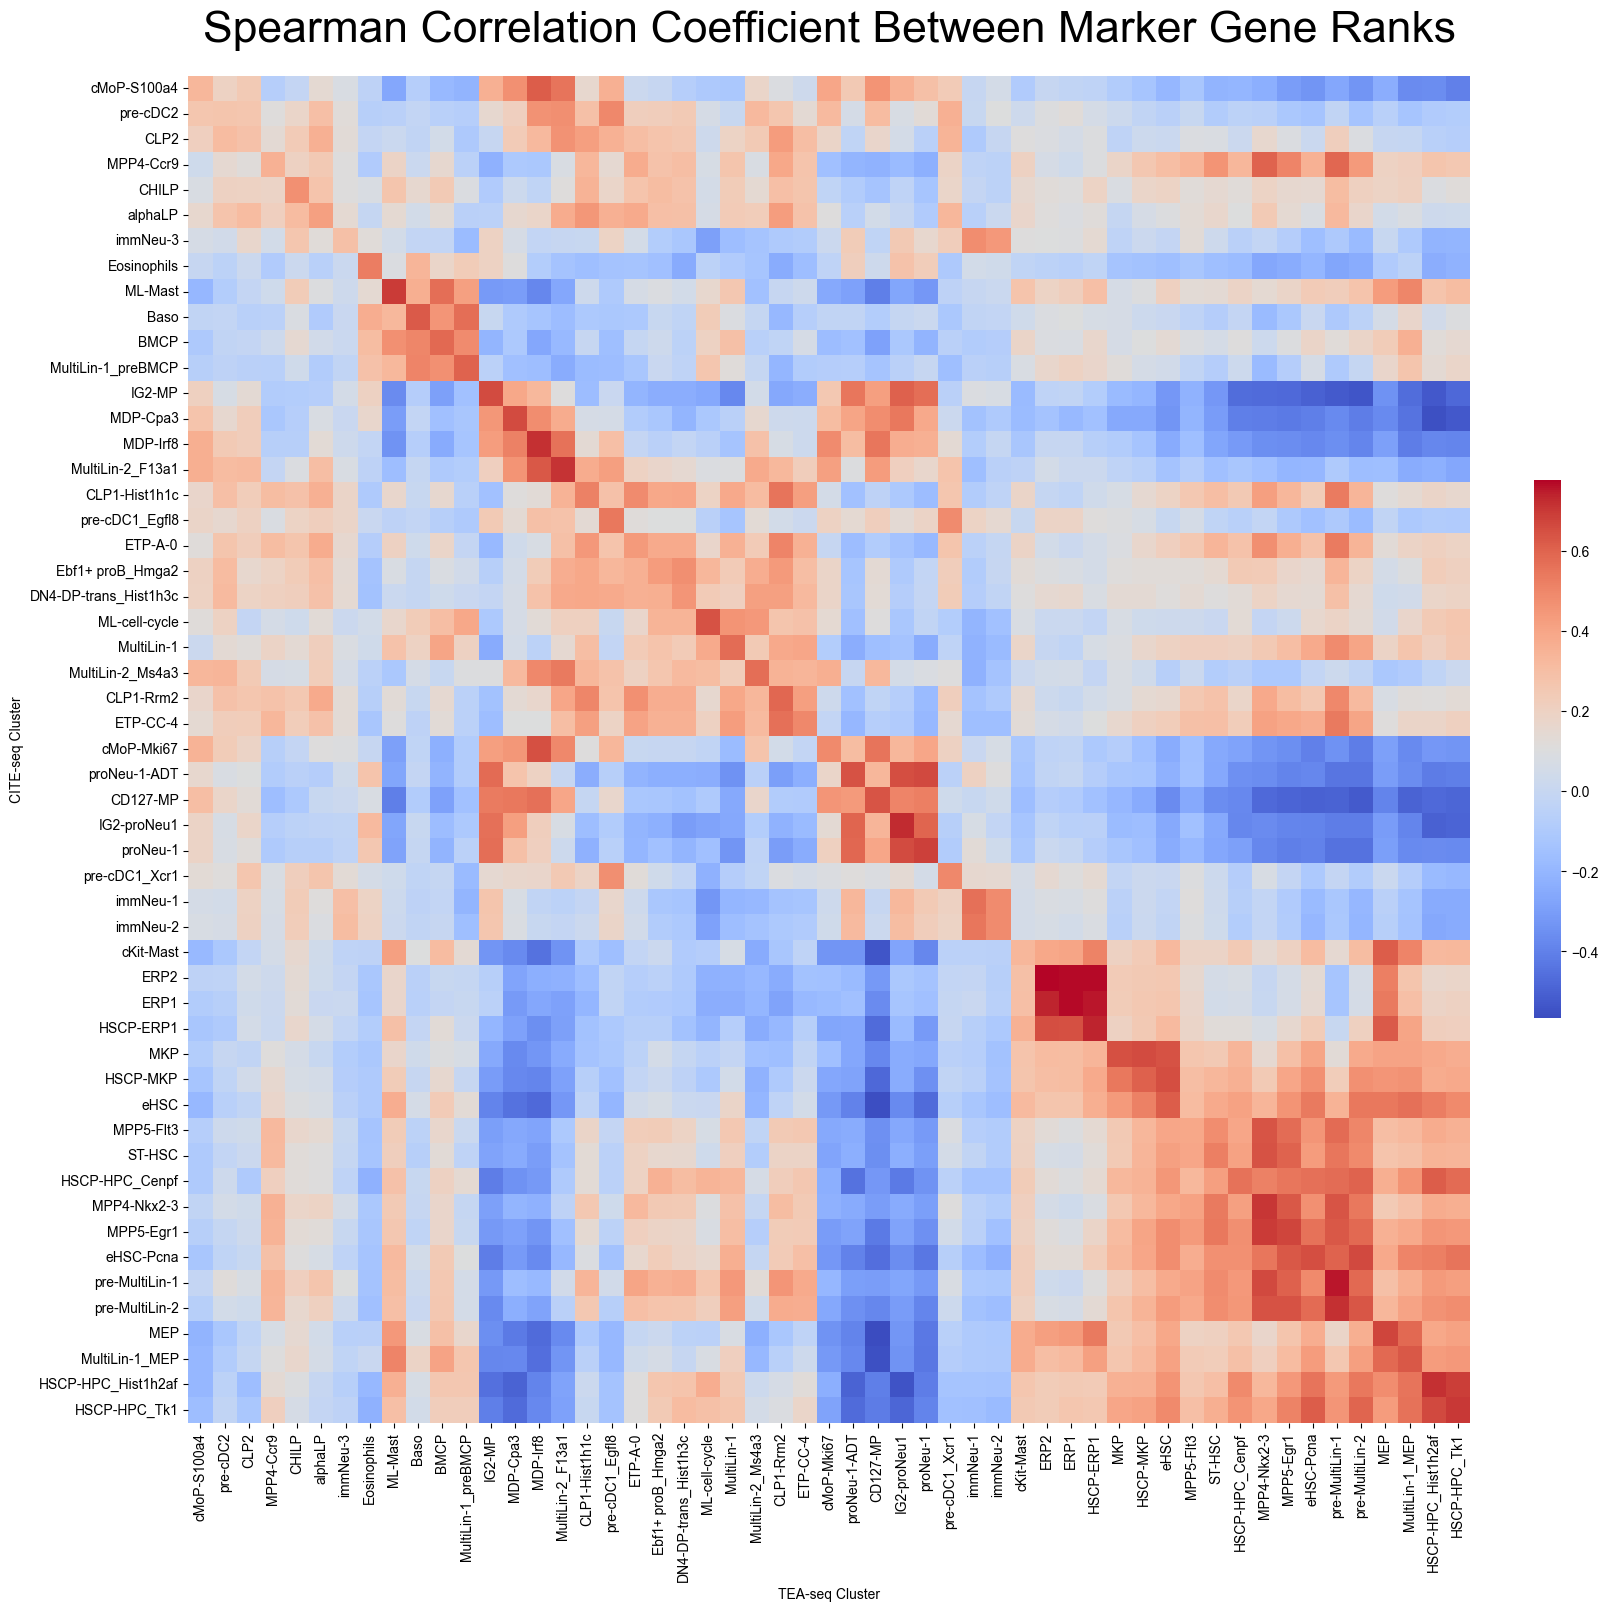

In [44]:

# Plot heatmap to compare TEA markers to CITE seq
plt.close("all")
fig = plt.figure(constrained_layout=True, figsize=(16,16))
ax = fig.add_subplot()
sns.heatmap(\
    spearman_mf_coefs_multilin.loc[\
        cite_ml_marker_genes[1]["top_cluster"].unique(),
        cite_ml_marker_genes[1]["top_cluster"].unique()],
    cmap="coolwarm",
    cbar_kws={'shrink': 0.4},
    ax=ax)

ax.set_ylabel("CITE-seq Cluster")
ax.set_xlabel("TEA-seq Cluster")
ax.set_title("Spearman Correlation Coefficient Between Marker Gene Ranks",
    fontdict = {\
        'fontsize': 32},
    pad = 25)

plt.savefig("output/validation_plots/"\
    "tea_seq_markers_vs_cite_seq_spearman_correlation_heatmap_multilin.pdf")

spearman_mf_coefs_multilin.loc[\
    cite_ml_marker_genes[1]["top_cluster"].unique(),
    cite_ml_marker_genes[1]["top_cluster"].unique()].to_csv(\
        "output/validation_plots/"\
        "tea_seq_markers_vs_cite_seq_spearman_correlation_heatmap_multilin.csv",
        header=True, index=True, index_label="Cluster")


In [37]:
tea_hscp_top_25_marker_df = pd.read_csv(\
    "output/markerfinder/tea_transferred_hscp/top_25_cluster_markers.csv")

markers_hscp = np.unique([i.split(":")[0] for i in \
    tea_hscp_top_25_marker_df["marker"].values])

tea_hscp_top_25_marker_df

,UID,cluster,marker,rank,pearson_r,p_value
0,0,HSC-Mac_Fcna,Gm42418:Gm42418,1,0.315398,0.000000e+00
1,1,HSC-Mac_Fcna,Cacna1e:Cacna1e,2,0.232835,1.563852e-234
2,2,HSC-Mac_Fcna,Slamf7:Slamf7,3,0.193488,3.273923e-161
3,3,HSC-Mac_Fcna,Jchain:Jchain,4,0.174051,2.317389e-130
4,4,HSC-Mac_Fcna,Mzb1:Mzb1,5,0.172104,1.838314e-127
...,...,...,...,...,...,...
520,20,MKP,Pde5a:Pde5a,21,0.221120,3.773359e-211
521,21,MKP,Endod1:Endod1,22,0.217119,1.805489e-203
522,22,MKP,Ckap2l:Ckap2l,23,0.212560,6.628662e-195
523,23,MKP,Slc14a1:Slc14a1,24,0.208886,3.793928e-188


In [38]:
cite_hscp_mf_res = marker_finder(\
    pd.DataFrame(\
        rna_cite_hscp_logcptt[:,markers_hscp].X.toarray(),
        index=rna_cite_hscp_logcptt.obs.index.values,
        columns=markers_hscp),
    rna_cite_hscp_logcptt.obs["R7"].values)

In [39]:
tea_hscp_mf_res = marker_finder(\
    pd.DataFrame(\
        rna_tea_hscp[:,markers_hscp].X.toarray(),
        index=rna_tea_hscp.obs.index.values,
        columns=markers_hscp),
    rna_tea_hscp.obs["R7"].values)

In [40]:
# Calculate spearmanr coefficients between CITE and TEA groups
tmp_cite_groups = cite_hscp_mf_res[0].columns.values
tmp_tea_groups = tea_hscp_mf_res[0].columns.values

spearman_mf_coefs_hscp = {}
for tmp_tea_group in tmp_tea_groups:
    tmp_spear_list = []
    for tmp_cite_group in tmp_cite_groups:
        tmp_spear = spearmanr(\
            pd.DataFrame({\
                "TEA": tea_hscp_mf_res[0].loc[\
                    markers_hscp, tmp_tea_group],
                "CITE": cite_hscp_mf_res[0].loc[\
                    markers_hscp, tmp_cite_group]}).fillna(0))
        tmp_spear_list.append(tmp_spear.correlation)
    
    spearman_mf_coefs_hscp[tmp_tea_group] = pd.Series(\
        tmp_spear_list,
        index=tmp_cite_groups)
        
spearman_mf_coefs_hscp = pd.DataFrame(spearman_mf_coefs_hscp)

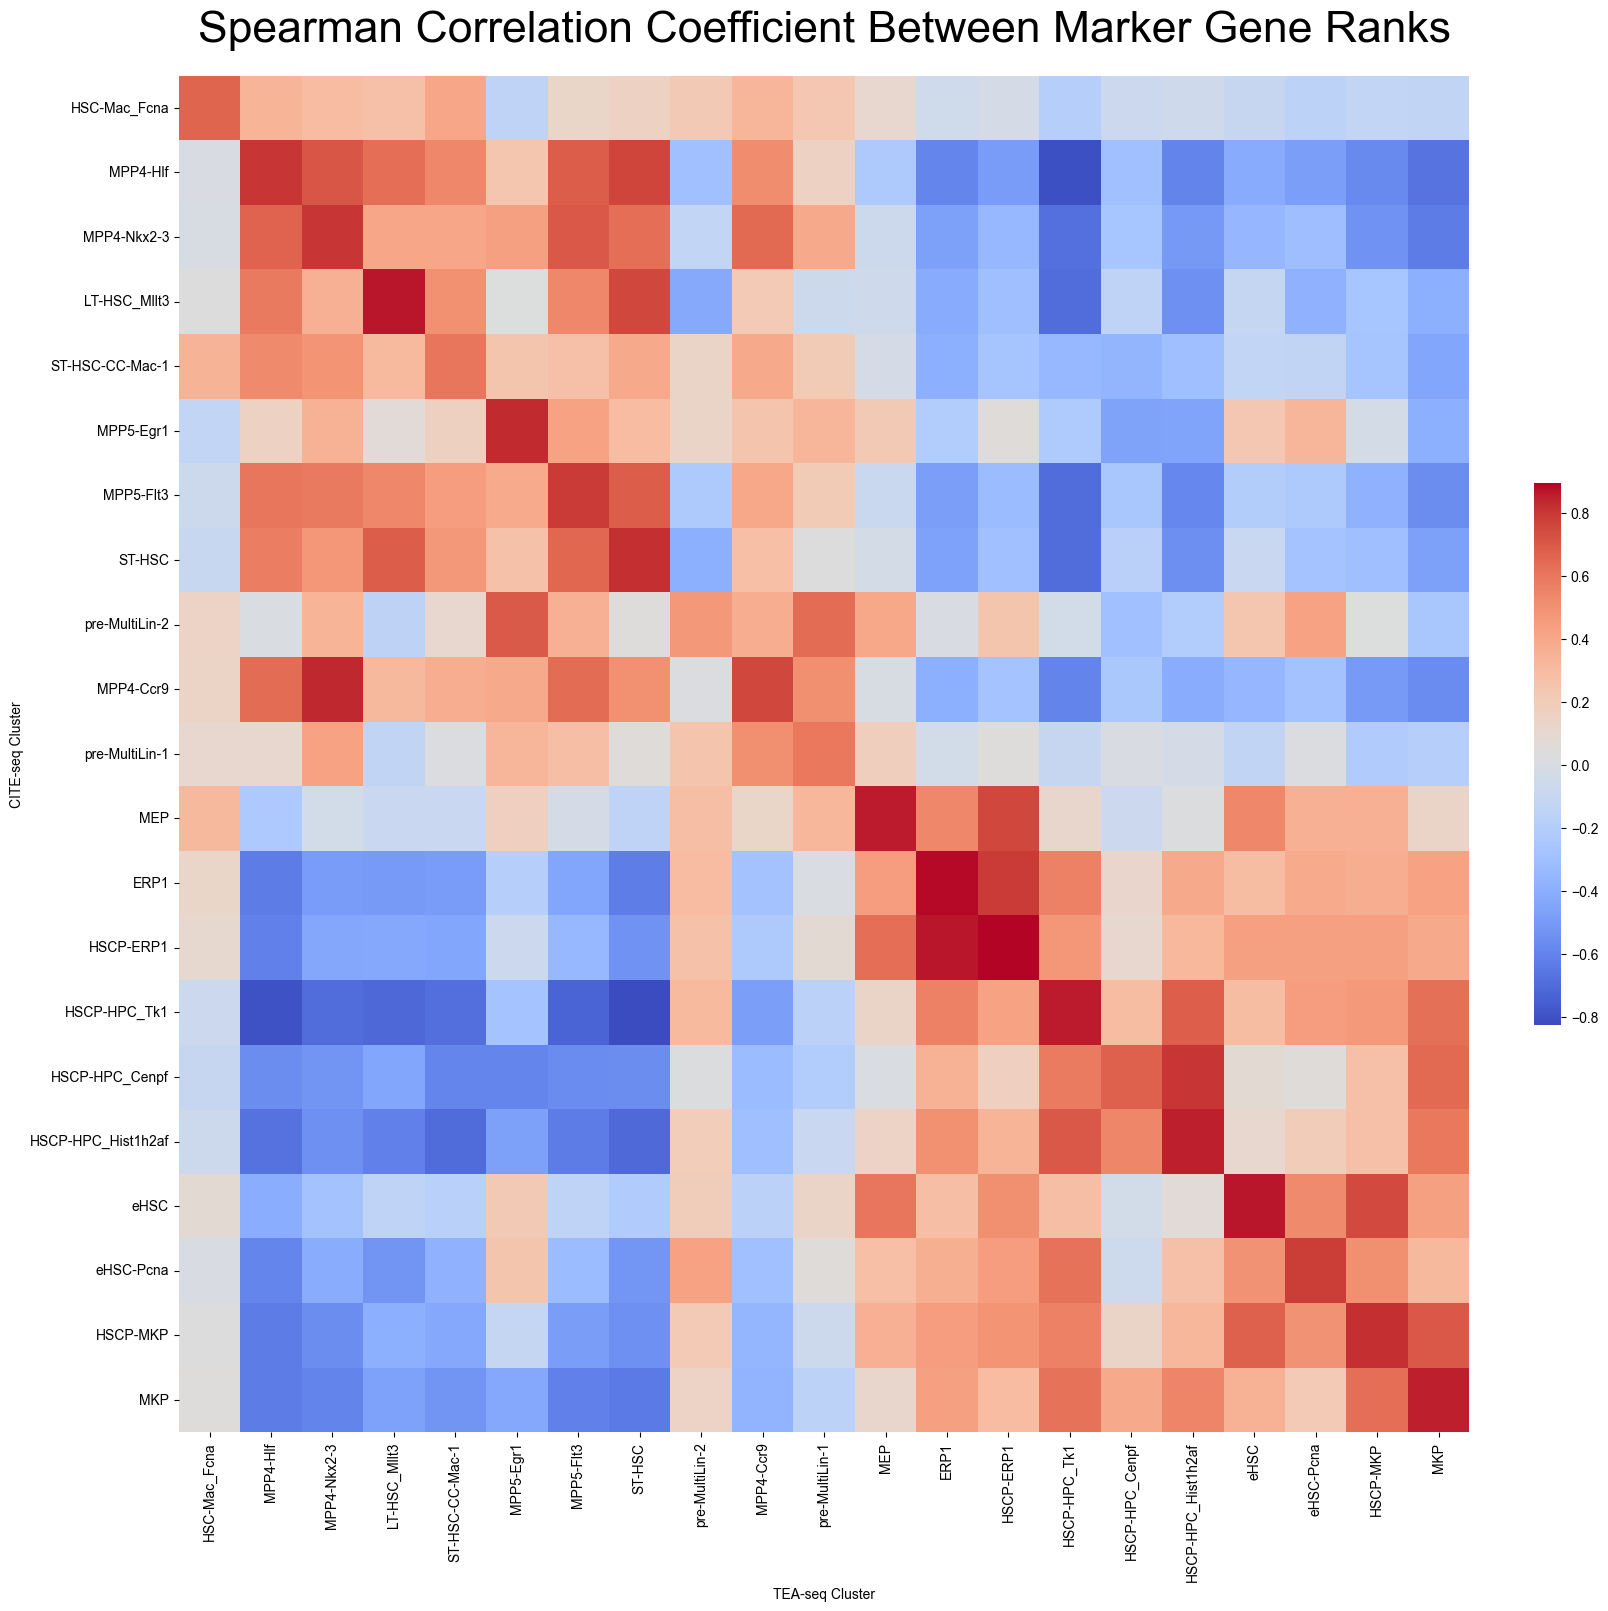

In [43]:

# Plot heatmap to compare TEA markers to CITE seq
plt.close("all")
fig = plt.figure(constrained_layout=True, figsize=(16,16))
ax = fig.add_subplot()
sns.heatmap(\
    spearman_mf_coefs_hscp.loc[\
        cite_hscp_marker_genes[1]["top_cluster"].unique(),
        cite_hscp_marker_genes[1]["top_cluster"].unique()],
    cmap="coolwarm",
    cbar_kws={'shrink': 0.4},
    ax=ax)

ax.set_ylabel("CITE-seq Cluster")
ax.set_xlabel("TEA-seq Cluster")
ax.set_title("Spearman Correlation Coefficient Between Marker Gene Ranks",
    fontdict = {\
        'fontsize': 32},
    pad = 25)

plt.savefig("output/validation_plots/"\
    "tea_seq_markers_vs_cite_seq_spearman_correlation_heatmap_hscp.pdf")

spearman_mf_coefs_hscp.loc[\
        cite_hscp_marker_genes[1]["top_cluster"].unique(),
        cite_hscp_marker_genes[1]["top_cluster"].unique()].to_csv(\
            "output/validation_plots/"\
            "tea_seq_markers_vs_cite_seq_spearman_correlation_heatmap_hscp.csv",
            header=True, index=True, index_label="Cluster")



In [65]:
map_r7_v1_v2 = pd.read_csv("input/map_r7-v1_to_r7-v2_names.csv")

map_r7_v1_to_v2 = pd.Series(\
    map_r7_v1_v2["R7_V2"].values,
    index=map_r7_v1_v2["R7_V1"].values)

map_r7_v1_to_v2

neoHSC-Mlt3_HSC-c5--RNA                 LT-HSC_Mllt3
neoHSC-Mlt3--Ex                               ST-HSC
neoHSC-Mlt3_HSC-c2--RNA              ST-HSC-CC-Mac-1
neoHSC-Mlt3_16-1--ADT                ST-HSC-CC-Mac-2
eHSC_HSC-c10--RNA                               eHSC
                                        ...         
Bcl11b+_preETP_CD127-c6--RNA     Bcl11b+_preETP_Cd3d
Bcl11b+_preETP--Ex              Bcl11b+_preETP_Tdrd5
EILP_12-4--ADT                                  EILP
precursor_B_cell--Ex                     pre-B-Il2ra
precursor_B_cell_5-2--ADT               pre-B-Fcer2a
Length: 90, dtype: object

In [66]:
# Check against separate clustering that seemed to be from Nathan and not Frank
old_clusters_2 = pd.read_table("input/nathan_cite_to_tea_groups.txt")

old_clusters_2["port"] = [i.split("-")[-1] for i in old_clusters_2["barcode"].values]
old_clusters_2["barcode"] = [i.split("-")[0] + "-1" for i in old_clusters_2["barcode"].values]

port_old_to_port_new = {\
    "1": "AS_TEAr_H1",
    "2": "AS_TEAr_H2",
    "3": "AS_TEAr_M1",
    "4": "AS_TEAr_M2"}

old_clusters_2["port"] = old_clusters_2["port"].replace(port_old_to_port_new)

old_clusters_2.index = old_clusters_2["barcode"] + "." + old_clusters_2["port"]

old_clusters_2["R7"] = old_clusters_2["cell_type"].replace(map_r7_v1_to_v2.to_dict())

old_clusters_2

,barcode,cell_type,UMAP1,UMAP2,port,R7
CATCCTGGTGGATTGC-1.AS_TEAr_H2,CATCCTGGTGGATTGC-1,neoHSC-Mlt3_HSC-c5--RNA,-9.883736,-2.751858,AS_TEAr_H2,LT-HSC_Mllt3
ATCAAGCTCAGCTAAC-1.AS_TEAr_H2,ATCAAGCTCAGCTAAC-1,neoHSC-Mlt3_HSC-c5--RNA,-11.015314,-3.984825,AS_TEAr_H2,LT-HSC_Mllt3
CCAAACTAGGCTTAGT-1.AS_TEAr_H1,CCAAACTAGGCTTAGT-1,neoHSC-Mlt3_HSC-c5--RNA,-10.015392,-2.790317,AS_TEAr_H1,LT-HSC_Mllt3
TTGCTCTCAGCACCAT-1.AS_TEAr_H2,TTGCTCTCAGCACCAT-1,neoHSC-Mlt3_HSC-c5--RNA,-9.448926,-3.487058,AS_TEAr_H2,LT-HSC_Mllt3
CCTAGTTGTATGGTGC-1.AS_TEAr_H2,CCTAGTTGTATGGTGC-1,neoHSC-Mlt3_HSC-c5--RNA,-10.158329,-3.421886,AS_TEAr_H2,LT-HSC_Mllt3
...,...,...,...,...,...,...
TTAACTGAGAAAGGAA-1.AS_TEAr_M2,TTAACTGAGAAAGGAA-1,DN4-DP-trans-Hist1h3c_CD127-c12--RNA,-1.063014,4.326897,AS_TEAr_M2,DN4-DP-trans_Hist1h3c
CAATGTCAGAATCTCA-1.AS_TEAr_H1,CAATGTCAGAATCTCA-1,DN4-DP-trans-Hist1h3c_CD127-c12--RNA,-1.451453,5.243823,AS_TEAr_H1,DN4-DP-trans_Hist1h3c
CGTGACATCCTGGTGA-1.AS_TEAr_H2,CGTGACATCCTGGTGA-1,DN4-DP-trans-Hist1h3c_CD127-c12--RNA,-1.500835,5.307752,AS_TEAr_H2,DN4-DP-trans_Hist1h3c
CCTCCTGAGGTTAGAG-1.AS_TEAr_M2,CCTCCTGAGGTTAGAG-1,DN4-DP-trans-Hist1h3c_CD127-c12--RNA,-0.955323,4.127751,AS_TEAr_M2,DN4-DP-trans_Hist1h3c


In [62]:
tmp_new = rna_tea_merged.obs.loc[rna_tea_merged.obs["sample"] == "AS_TEAr_M2", "cell"].values
tmp_old = old_clusters_2.loc[old_clusters_2["port"] == "4", "barcode"].values

print("{} of {} cells shared to new annotation file.".format(\
   len(np.intersect1d(tmp_new, tmp_old)),
   len(tmp_new)))



14071 of 14496 cells shared to new annotation file.


In [52]:

# unique_new_labels = tea_cell_anno["R7"].unique()
# percent_overlaps = pd.DataFrame(0, columns=unique_new_labels, index=unique_new_labels)
# for tmp_cluster in unique_new_labels:
#     tmp_new = tea_cell_anno.loc[tea_cell_anno["R7"] == tmp_cluster].index.values
#     tmp_old = old_clusters_2[old_clusters_2["R7"] == tmp_cluster].index.values
#     percent_

array(['CCAAACTAGGCTTAGT-1', 'CGCTAATAGGTGTTAC-1', 'TTCCCGCCAACTCGCG-1',
       ..., 'TGTTGGCCACAGGAAT-1', 'AGCGGATAGGGACGCA-1',
       'CAATGTCAGAATCTCA-1'], dtype=object)

In [69]:
shared_cells = np.intersect1d(\
    tea_cell_anno.index.values,
    old_clusters_2.index.values)

compare_labels = pd.DataFrame({\
    "new": tea_cell_anno.loc[shared_cells, "R7"],
    "old": old_clusters_2.loc[shared_cells, "R7"]},
    index=shared_cells)

compare_labels["test"] = compare_labels["new"] == compare_labels["old"]

compare_labels.sum()

new     ST-HSCST-HSCML-MastML-cell-cycleMultiLin-2_F13...
old     MPP4-HlfMPP4-HlfML-MastMEP-UNKMultiLin-2_Ms4a3...
test                                                 9457
dtype: object

Finding markers for Infinity Flow object...
Plotting markers...


'ST-HSC-CC-Mac-2'
Warning! Failed to run plot_markers_df. See above Exception.


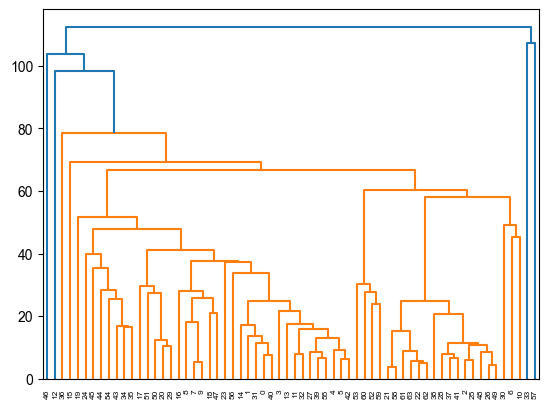

In [73]:
# Filter to multilin tea_seq data and find RNA markers
# Old cell annotation transfer
tmp_barcodes = old_clusters_2.loc[shared_cells].loc[\
    old_clusters_2.loc[shared_cells, "port"].isin([\
        "AS_TEAr_M1",
        "AS_TEAr_M2"])].index.values

rna_tea_multilin_old_labels = rna_tea_multilin[tmp_barcodes,:].copy()

rna_tea_multilin_old_labels.obs["R7"] = old_clusters_2.loc[\
    rna_tea_multilin_old_labels.obs.index.values,
    "R7"].values

## Gene selection
tmp_cells_per_gene = pd.Series((\
    rna_tea_multilin_old_labels.X > 0).toarray().sum(axis=0).reshape(-1),
    index=rna_tea_multilin_old_labels.var.index.values)

# Force genes to be above 0 log2 cptt in at least 25 cells
tmp_cells_per_gene = tmp_cells_per_gene[tmp_cells_per_gene > 25]

# Exclude mitochondrial genes
tmp_cells_per_gene = tmp_cells_per_gene.loc[\
    ~tmp_cells_per_gene.index.str.startswith("mt-")]

tmp_input_adata = rna_tea_multilin_old_labels[:,tmp_cells_per_gene.index.values].copy()
tmp_input_adata.X = tmp_input_adata.X.toarray()

cite_ml_marker_genes_old_transfer = find_markers_from_anndata(\
    tmp_input_adata, 
    output_dir="output/markerfinder/old_transfer_multilin/", 
    groups_to_colors=tmp_colors_r7, 
    top_n_markers=25, 
    cluster_key='R7', 
    verbosity=3)

In [129]:
tea_multilin_top_25_marker_df = pd.read_csv(\
    "output/markerfinder/old_transfer_multilin/top_25_cluster_markers.csv")

markers_multilin = np.unique([i.split(":")[0] for i in \
    tea_multilin_top_25_marker_df["marker"].values])

tea_multilin_top_25_marker_df

,UID,cluster,marker,rank,pearson_r,p_value
0,0,alphaLP,Spred3:Spred3,1,0.114666,1.014865e-68
1,1,alphaLP,Pard3bos1:Pard3bos1,2,0.108588,8.903525e-62
2,2,alphaLP,Map3k12:Map3k12,3,0.105326,3.290395e-58
3,3,alphaLP,Dscam:Dscam,4,0.103686,1.858420e-56
4,4,alphaLP,Oas2:Oas2,5,0.103403,3.704488e-56
...,...,...,...,...,...,...
1595,20,pre-cDC1_Xcr1,Upp2:Upp2,21,0.115757,5.245090e-70
1596,21,pre-cDC1_Xcr1,B430306N03Rik:B430306N03Rik,22,0.115622,7.563850e-70
1597,22,pre-cDC1_Xcr1,Irf2bpl:Irf2bpl,23,0.109896,3.074667e-63
1598,23,pre-cDC1_Xcr1,Raph1:Raph1,24,0.103941,9.978957e-57


In [130]:
cite_multilin_mf_res = marker_finder(\
    pd.DataFrame(\
        rna_cite_ml_logcptt[:,markers_multilin].X.toarray(),
        index=rna_cite_ml_logcptt.obs.index.values,
        columns=markers_multilin),
    rna_cite_ml_logcptt.obs["R7"].values)

In [131]:
tea_multilin_mf_res = marker_finder(\
    pd.DataFrame(\
        rna_tea_multilin_old_labels[:,markers_multilin].X.toarray(),
        index=rna_tea_multilin_old_labels.obs.index.values,
        columns=markers_multilin),
    rna_tea_multilin_old_labels.obs["R7"].values)

In [132]:
# Calculate spearmanr coefficients between CITE and TEA groups
from scipy.stats import spearmanr

tmp_cite_groups = cite_multilin_mf_res[0].columns.values
tmp_tea_groups = tea_multilin_mf_res[0].columns.values

tmp_shared_groups = np.intersect1d(\
    tmp_cite_groups,
    tmp_tea_groups)

spearman_mf_coefs_multilin = {}
for tmp_tea_group in tmp_shared_groups:
    tmp_spear_list = []
    for tmp_cite_group in tmp_shared_groups:
        tmp_spear = spearmanr(\
            pd.DataFrame({\
                "TEA": tea_multilin_mf_res[0].loc[\
                    markers_multilin, tmp_tea_group],
                "CITE": cite_multilin_mf_res[0].loc[\
                    markers_multilin, tmp_cite_group]}).fillna(0))
        tmp_spear_list.append(tmp_spear.correlation)
    
    spearman_mf_coefs_multilin[tmp_tea_group] = pd.Series(\
        tmp_spear_list,
        index=tmp_shared_groups)
        
spearman_mf_coefs_multilin = pd.DataFrame(spearman_mf_coefs_multilin)

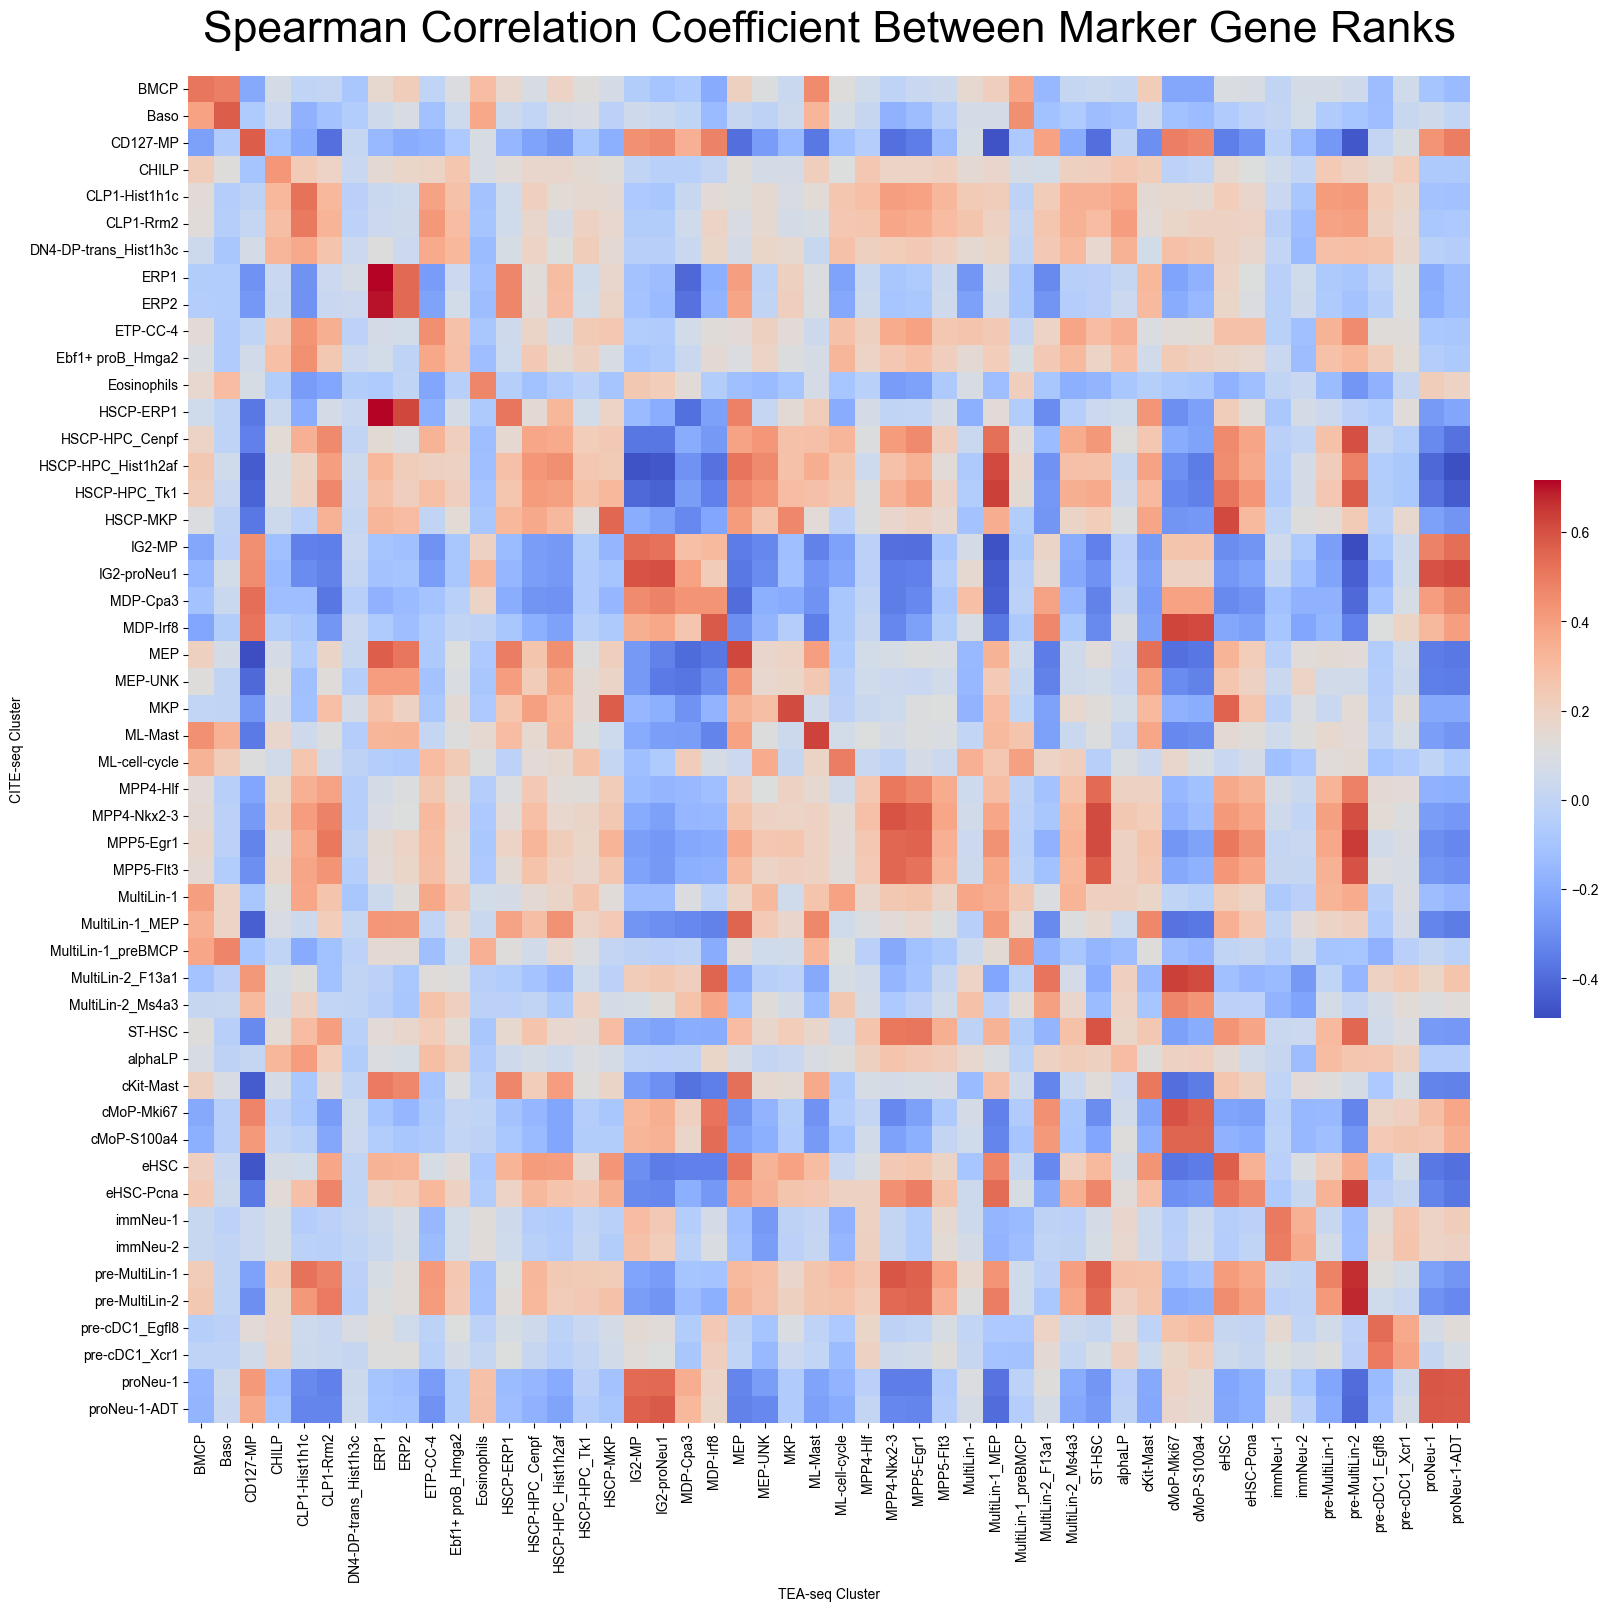

In [133]:

# Plot heatmap to compare TEA markers to CITE seq
plt.close("all")
fig = plt.figure(constrained_layout=True, figsize=(16,16))
ax = fig.add_subplot()
sns.heatmap(\
    spearman_mf_coefs_multilin.loc[\
        tmp_shared_groups,
        tmp_shared_groups],
    cmap="coolwarm",
    cbar_kws={'shrink': 0.4},
    ax=ax)

ax.set_ylabel("CITE-seq Cluster")
ax.set_xlabel("TEA-seq Cluster")
ax.set_title("Spearman Correlation Coefficient Between Marker Gene Ranks",
    fontdict = {\
        'fontsize': 32},
    pad = 25)

plt.savefig("output/validation_plots/"\
    "tea_seq_markers_vs_cite_seq_spearman_correlation_heatmap_multilin_old.pdf")

spearman_mf_coefs_multilin.loc[\
    tmp_shared_groups,
    tmp_shared_groups].to_csv(\
        "output/validation_plots/"\
        "tea_seq_markers_vs_cite_seq_spearman_correlation_heatmap_multilin_old.csv",
        header=True, index=True, index_label="Cluster")


In [134]:
tmp_old_spearman_results = pd.read_csv("output/validation_plots/"\
    "tea_seq_markers_vs_cite_seq_spearman_correlation_heatmap_multilin_old.csv",
    index_col=0)

tmp_new_spearman_results = pd.read_csv("output/validation_plots/"\
    "tea_seq_markers_vs_cite_seq_spearman_correlation_heatmap_multilin.csv",
    index_col=0)

In [135]:
shared_spear_groups = np.intersect1d(\
    tmp_old_spearman_results.columns.values,
    tmp_new_spearman_results.columns.values)

shared_spear_groups

array(['BMCP', 'Baso', 'CD127-MP', 'CHILP', 'CLP1-Hist1h1c', 'CLP1-Rrm2',
       'DN4-DP-trans_Hist1h3c', 'ERP1', 'ERP2', 'ETP-CC-4',
       'Ebf1+ proB_Hmga2', 'Eosinophils', 'HSCP-ERP1', 'HSCP-HPC_Cenpf',
       'HSCP-HPC_Hist1h2af', 'HSCP-HPC_Tk1', 'HSCP-MKP', 'IG2-MP',
       'IG2-proNeu1', 'MDP-Cpa3', 'MDP-Irf8', 'MEP', 'MKP', 'ML-Mast',
       'ML-cell-cycle', 'MPP4-Nkx2-3', 'MPP5-Egr1', 'MPP5-Flt3',
       'MultiLin-1', 'MultiLin-1_MEP', 'MultiLin-1_preBMCP',
       'MultiLin-2_F13a1', 'MultiLin-2_Ms4a3', 'ST-HSC', 'alphaLP',
       'cKit-Mast', 'cMoP-Mki67', 'cMoP-S100a4', 'eHSC', 'eHSC-Pcna',
       'immNeu-1', 'immNeu-2', 'pre-MultiLin-1', 'pre-MultiLin-2',
       'pre-cDC1_Egfl8', 'pre-cDC1_Xcr1', 'proNeu-1', 'proNeu-1-ADT'],
      dtype=object)

In [136]:
comp_spear_scores = pd.DataFrame({\
    "old": [tmp_old_spearman_results.loc[i,i] for i in shared_spear_groups],
    "new": [tmp_new_spearman_results.loc[i,i] for i in shared_spear_groups]},
    index=shared_spear_groups)

print(comp_spear_scores.to_string())

                            old       new
BMCP                   0.512222  0.587256
Baso                   0.573922  0.620267
CD127-MP               0.573746  0.636411
CHILP                  0.424546  0.469002
CLP1-Hist1h1c          0.522548  0.519028
CLP1-Rrm2              0.329575  0.589205
DN4-DP-trans_Hist1h3c  0.035046  0.456189
ERP1                   0.715414  0.768465
ERP2                   0.545805  0.777566
ETP-CC-4               0.447971  0.497105
Ebf1+ proB_Hmga2       0.283589  0.435904
Eosinophils            0.468696  0.527809
HSCP-ERP1              0.513748  0.736909
HSCP-HPC_Cenpf         0.377153  0.559377
HSCP-HPC_Hist1h2af     0.448414  0.717565
HSCP-HPC_Tk1           0.271563  0.703723
HSCP-MKP               0.547901  0.604738
IG2-MP                 0.535702  0.657529
IG2-proNeu1            0.602369  0.729329
MDP-Cpa3               0.429865  0.658962
MDP-Irf8               0.577089  0.715749
MEP                    0.620681  0.676168
MKP                    0.612586  0

In [137]:
(comp_spear_scores["new"] - comp_spear_scores["old"]).mean()

0.11436260434437673

In [138]:
comp_spear_scores.to_csv("output/validation_plots/"\
    "compare_new_vs_old_spearman_correlations_from_tea_to_cite.csv",
    header=True, index=True, index_label="cluster")